# All imports in one place

In [1]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, TFBertModel, TFAutoModel
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.losses import CategoricalFocalCrossentropy
from collections import Counter
from sklearn.utils import resample

2025-08-08 21:12:24.405148: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754687544.600870      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754687544.657057      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def summarize_training_data(csv_path, label_columns=['Sentiment', 'Sarcasm', 'Vulgar', 'Abuse']):
    """
    Analyze and summarize the training CSV file with detailed statistics
    
    Args:
        csv_path: Path to the training CSV file
        label_columns: List of column names containing class labels
    """
    # Load the data
    df = pd.read_csv(csv_path)
    
    # Basic info
    print(f"📊 Dataset Summary: {csv_path}")
    print(f"📝 Total Samples: {len(df):,}")
    print(f"🔢 Total Features: {len(df.columns)}\n")
    
    # Initialize summary dataframe
    summary = pd.DataFrame({
        'column': df.columns,
        'dtype': df.dtypes.values,
        'null_count': df.isnull().sum().values,
        'null_pct': (df.isnull().mean() * 100).round(2).values,
        'unique_count': df.nunique().values
    })
    
    # Add unique values preview
    summary['unique_values'] = summary.apply(
        lambda row: list(df[row['column']].unique()) if row['unique_count'] <= 20 else f"{row['unique_count']} unique values",
        axis=1
    )
    
    # Display general summary
    print("🧾 COLUMNS SUMMARY:")
    print(summary.to_markdown(index=False, tablefmt="grid"))
    print("\n")
    
    # Detailed analysis for label columns
    print("🏷️ LABEL DISTRIBUTIONS:")
    for col in label_columns:
        if col in df.columns:
            print(f"\n🔖 {col} Distribution:")
            dist = df[col].value_counts(dropna=False).reset_index()
            dist.columns = ['Value', 'Count']
            dist['Percentage'] = (dist['Count'] / len(df) * 100).round(2)
            
            # Add example text for minority classes
            if dist['Count'].min() < 10:  # Show examples for rare classes
                dist['Examples'] = dist.apply(
                    lambda x: df[df[col] == x['Value']]['OCR'].head(3).tolist() if x['Count'] < 10 else '',
                    axis=1
                )
            print(dist.to_markdown(index=False, tablefmt="grid"))
        else:
            print(f"⚠️ Label column '{col}' not found in dataset")

    # OCR text analysis
    if 'OCR' in df.columns:
        print("\n📖 OCR TEXT ANALYSIS:")
        
        # Handle NaN values by filling with empty string
        df['OCR'] = df['OCR'].fillna('')
        
        # Calculate word counts safely
        df['ocr_length'] = df['OCR'].apply(lambda x: len(str(x).split()))
        
        # Basic statistics
        print(f"📐 Average word count: {df['ocr_length'].mean():.1f}")
        print(f"📏 Min word count: {df['ocr_length'].min()}")
        print(f"📏 Max word count: {df['ocr_length'].max()}")
        
        # Most common words analysis
        try:
            all_words = ' '.join(df['OCR'].astype(str)).split()
            if len(all_words) > 0:
                word_counts = pd.Series(all_words).value_counts()
                print(f"📈 Most common words: {word_counts.head(5).to_dict()}")
            else:
                print("📈 No words found in OCR text")
        except Exception as e:
            print(f"⚠️ Error analyzing common words: {str(e)}")

# Usage example:
summarize_training_data("/kaggle/input/hasoc-train-and-test-dataset/Bangla_train_data.csv")

📊 Dataset Summary: /kaggle/input/hasoc-train-and-test-dataset/Bangla_train_data.csv
📝 Total Samples: 2,693
🔢 Total Features: 7

🧾 COLUMNS SUMMARY:
+-----------+---------+--------------+------------+----------------+-------------------------------------+
| column    | dtype   |   null_count |   null_pct |   unique_count | unique_values                       |
+===========+=========+==============+============+================+=====================================+
| Ids       | object  |            0 |       0    |           2693 | 2693 unique values                  |
+-----------+---------+--------------+------------+----------------+-------------------------------------+
| Sentiment | object  |            0 |       0    |              3 | ['Neutral', 'Negative', 'Positive'] |
+-----------+---------+--------------+------------+----------------+-------------------------------------+
| Sarcasm   | object  |            0 |       0    |              2 | ['Sarcastic', 'Non-Sarcastic']     

In [4]:
import os
import pandas as pd
from PIL import Image
from collections import Counter

def print_test_dataset_summary(csv_path, image_folder):
    """
    Analyze test dataset and print beautiful summary to console
    
    Args:
        csv_path (str): Path to test CSV file with 'Ids' and 'OCR' columns
        image_folder (str): Path to folder containing images
    """
    # Read CSV file
    df = pd.read_csv(csv_path)
    
    # Validate columns
    if not {'Ids', 'OCR'}.issubset(df.columns):
        print("❌ Error: CSV must contain 'Ids' and 'OCR' columns")
        return
    
    # Create full image paths
    df['image_path'] = df['Ids'].apply(lambda x: os.path.join(image_folder, x))
    
    # Initialize counters
    stats = {
        'total_samples': len(df),
        'unique_ocr': df['OCR'].nunique(),
        'missing_ocr': df['OCR'].isnull().sum(),
        'empty_ocr': (df['OCR'] == '').sum(),
        'missing_images': [],
        'extensions': [],
        'corrupt_images': []
    }
    
    # Analyze images
    for idx, row in df.iterrows():
        img_path = row['image_path']
        
        if not os.path.exists(img_path):
            stats['missing_images'].append(row['Ids'])
            continue
            
        ext = os.path.splitext(img_path)[1].lower()
        stats['extensions'].append(ext)
        
        try:
            with Image.open(img_path) as img:
                img.verify()
        except (IOError, SyntaxError) as e:
            stats['corrupt_images'].append(row['Ids'])

    # Count extensions
    ext_counts = Counter(stats['extensions'])
    
    # Print beautiful summary
    print("\n" + "="*50)
    print("📊 TEST DATASET SUMMARY".center(50))
    print("="*50)
    
    print("\n🔢 BASIC STATISTICS:")
    print(f"- Total samples: {stats['total_samples']}")
    print(f"- Unique OCR texts: {stats['unique_ocr']}")
    print(f"- Missing OCR (null): {stats['missing_ocr']}")
    print(f"- Empty OCR strings: {stats['empty_ocr']}")
    
    print("\n🖼️ IMAGE ANALYSIS:")
    print(f"- Missing images: {len(stats['missing_images'])}")
    if stats['missing_images']:
        print("  Sample missing files:")
        for i, img_id in enumerate(stats['missing_images'][:5]):
            print(f"  {i+1}. {img_id}")
        if len(stats['missing_images']) > 5:
            print(f"  ...and {len(stats['missing_images']) - 5} more")
    
    print("\n📂 FILE EXTENSIONS:")
    for ext, count in ext_counts.most_common():
        print(f"- {ext}: {count} ({count/stats['total_samples']:.1%})")
    
    print(f"\n⚠️ Corrupt images: {len(stats['corrupt_images'])}")
    if stats['corrupt_images']:
        print("  Sample corrupt files:")
        for i, img_id in enumerate(stats['corrupt_images'][:3]):
            print(f"  {i+1}. {img_id}")
        if len(stats['corrupt_images']) > 3:
            print(f"  ...and {len(stats['corrupt_images']) - 3} more")
    
    print("\n" + "="*50)
    print("✅ ANALYSIS COMPLETE".center(50))
    print("="*50 + "\n")

# Example usage
print_test_dataset_summary(
        csv_path="/kaggle/input/hasoc-train-and-test-dataset/bengali_test_data_wo_label.csv",
        image_folder="/kaggle/input/hasoc-train-and-test-dataset/Bangla_test_images"
    )


              📊 TEST DATASET SUMMARY              

🔢 BASIC STATISTICS:
- Total samples: 1821
- Unique OCR texts: 1688
- Missing OCR (null): 0
- Empty OCR strings: 0

🖼️ IMAGE ANALYSIS:
- Missing images: 0

📂 FILE EXTENSIONS:
- .jpg: 993 (54.5%)
- .png: 828 (45.5%)

⚠️ Corrupt images: 0

               ✅ ANALYSIS COMPLETE                



In [5]:
from pathlib import Path
import imghdr
from PIL import Image
import tensorflow as tf

# Directory containing your test images
image_folder = "/kaggle/input/hasoc-train-and-test-dataset/Bangla_test_images"

bad_files = []
convertible = []
unreadable = []

for p in Path(image_folder).rglob("*"):
    if p.is_file() and imghdr.what(p) is None:
        bad_files.append(p)

for p in bad_files:
    # First try TensorFlow decode
    try:
        data = tf.io.read_file(str(p))
        img = tf.image.decode_image(data, channels=3, expand_animations=False)
        convertible.append(p)
        continue  # If decode succeeds, move on
    except Exception:
        pass

    # Fall back to PIL
    try:
        with Image.open(p) as im:
            im = im.convert("RGB")  # If this raises, PIL couldn’t read it
            convertible.append(p)
    except Exception as e:
        unreadable.append((p, repr(e)))

print(f"Total flagged files: {len(bad_files)}")
print(f"Convertible with PIL or TF: {len(convertible)}")
print(f"Unreadable: {len(unreadable)}")
if unreadable:
    print("Unreadable files and errors:")
    for fn, err in unreadable:
        print(fn, "->", err)


/tmp/ipykernel_36/519846583.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr
I0000 00:00:1754687585.675066      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Total flagged files: 461
Convertible with PIL or TF: 461
Unreadable: 0


In [6]:
train_path = '/kaggle/input/hasoc-train-and-test-dataset/Bangla_train_data.csv'
train_df = pd.read_csv(train_path)

def get_dynamic_class_names(df):
    """Dynamically extract class names from dataframe while maintaining original keys"""
    return {
        "sentiment": sorted(df['Sentiment'].unique().tolist()),
        "sarcasm": sorted(df['Sarcasm'].unique().tolist()),
        "vulgar": sorted(df['Vulgar'].unique().tolist()),
        "abuse": sorted(df['Abuse'].unique().tolist())
    }

# Update your CONFIG with dynamic class names
CONFIG = {
    "image_size": (224, 224),
    "batch_size": 32,
    "epochs": 20,
    "learning_rate": 2e-5,
    "val_split": 0.2,
    "max_text_length": 128,
    "random_seed": 42,
    "class_names": get_dynamic_class_names(train_df)  # Add this after loading your dataframe
}

# Then set your seeds as before
tf.random.set_seed(CONFIG["random_seed"])
np.random.seed(CONFIG["random_seed"])
print(CONFIG["class_names"])

{'sentiment': ['Negative', 'Neutral', 'Positive'], 'sarcasm': ['Non-Sarcastic', 'Sarcastic'], 'vulgar': ['Non Vulgar', 'Vulgar'], 'abuse': ['Abusive', 'Non-abusive']}


In [7]:
class BanglaMemeClassifier:
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")
        self.label_encoders = {
            "sentiment": LabelEncoder().fit(CONFIG["class_names"]["sentiment"]),
            "sarcasm": LabelEncoder().fit(CONFIG["class_names"]["sarcasm"]),
            "vulgar": LabelEncoder().fit(CONFIG["class_names"]["vulgar"]),
            "abuse": LabelEncoder().fit(CONFIG["class_names"]["abuse"])
        }
        self.model = None
        self.history = None
        

    def create_datasets(self, csv_path, image_folder, is_test=False):
        """Create TensorFlow datasets from CSV and images with oversampling for training"""
        df = pd.read_csv(csv_path)
        
        # Create full image paths and verify existence
        df['image_path'] = df['Ids'].apply(lambda x: os.path.join(image_folder, x))
        df = df[df['image_path'].apply(os.path.exists)]
        
        if not is_test:
            # For training/validation, verify all required columns exist
            required_columns = ['Ids', 'OCR', 'Sentiment', 'Sarcasm', 'Vulgar', 'Abuse']
            missing_cols = set(required_columns) - set(df.columns)
            if missing_cols:
                raise ValueError(f"Training CSV missing required columns: {missing_cols}")
            
            # Encode all labels
            for task in self.label_encoders:
                df[f"{task}_encoded"] = self.label_encoders[task].transform(df[task.capitalize()]).astype('int32')
            
            # Perform oversampling for each task's minority classes
            df = self._oversample_minority_classes(df)
        else:
            # For test set, only require 'Ids' and 'OCR'
            required_columns = ['Ids', 'OCR']
            missing_cols = set(required_columns) - set(df.columns)
            if missing_cols:
                raise ValueError(f"Test CSV missing required columns: {missing_cols}")
            
            # Add dummy columns for test set compatibility
            for task in self.label_encoders:
                df[f"{task}_encoded"] = 0  # Dummy values
        
        # Create dataset
        dataset = tf.data.Dataset.from_tensor_slices((
            df['image_path'].values,
            df['OCR'].values.astype('str'),
            *[df[f"{task}_encoded"].values.astype('int32') for task in self.label_encoders]
        ))
        
        # Map preprocessing function
        dataset = dataset.map(
            lambda path, text, *labels: self._preprocess_sample(path, text, labels, is_test),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        
        if not is_test:
            # Split into train/val - IMPORTANT: split AFTER oversampling
            dataset_size = len(df)
            dataset = dataset.shuffle(dataset_size, seed=CONFIG["random_seed"], 
                          reshuffle_each_iteration=False)
            val_size = int(CONFIG["val_split"] * dataset_size)
            train_dataset = dataset.skip(val_size)
            val_dataset = dataset.take(val_size)

            # Apply augmentation only to training dataset
            augmentation_layer = self._get_augmentation_layer()
            
            def augment_data(image, inputs):
                """Apply augmentation to image only"""
                inputs['image_input'] = augmentation_layer(image)
                return inputs
            
            train_dataset = train_dataset.map(
                lambda x, y: (augment_data(x['image_input'], x), y,
                num_parallel_calls=tf.data.AUTOTUNE
            )
            
            # Batch and optimize
            train_dataset = train_dataset.batch(CONFIG["batch_size"]).prefetch(tf.data.AUTOTUNE)
            val_dataset = val_dataset.batch(CONFIG["batch_size"]).prefetch(tf.data.AUTOTUNE)
            
            return train_dataset, val_dataset
        else:
            # For test set, maintain original order and return IDs
            return dataset.batch(CONFIG["batch_size"]), df['Ids'].values
    

    
    def _get_augmentation_layer(self):
        """Create image augmentation layer"""
        return tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.1),
            tf.keras.layers.RandomContrast(0.1),
            # Add more augmentations as needed
        ])

    
    def _oversample_minority_classes(self, df):
        """
        Multi-task oversampling:
        For each task t, compute per-class factor f_tk = ceil(max_count_t / count_tk).
        For each row i, replication r_i = max_t f_t, y_t(i).
        Repeat each row r_i times.
        """
        import numpy as np
        tasks = list(self.label_encoders.keys())
        rep = np.ones(len(df), dtype=int)
    
        for task in tasks:
            col = task.capitalize()
            counts = df[col].value_counts()
            max_c = counts.max()
            # factor for each class label in this task
            factors = {cls: int(np.ceil(max_c / cnt)) for cls, cnt in counts.items()}
            rep = np.maximum(rep, df[col].map(factors).values)
    
        df_balanced = df.loc[df.index.repeat(rep)].sample(
            frac=1, random_state=CONFIG["random_seed"]
        ).reset_index(drop=True)
        return df_balanced
    


    
    def _preprocess_sample(self, path, text, labels, is_test):
        """Preprocess a single sample with proper type handling"""
        def safe_decode(path_str):
            # Read file into bytes
            data = tf.io.read_file(path_str)
            try:
                # First try TensorFlow's generic decoder
                img = tf.image.decode_image(data, channels=3, expand_animations=False)
                return img
            except tf.errors.InvalidArgumentError:
                # Fall back to PIL
                import io
                from PIL import Image
                import numpy as np
                with tf.io.gfile.GFile(path_str, 'rb') as f:
                    pil_img = Image.open(io.BytesIO(f.read())).convert('RGB')
                return tf.convert_to_tensor(np.array(pil_img), dtype=tf.uint8)
        # Image processing
        if is_test:
            # Use tf.py_function so we can run Python code (PIL) in eager mode
            img = tf.py_function(
                lambda p: safe_decode(p.numpy().decode('utf-8')),
                [path],
                tf.uint8)
            # Set static shape for graph building
            img.set_shape((*CONFIG["image_size"], 3))
        else:
            # Fast path: assume training/validation images are clean
            data = tf.io.read_file(path)
            img = tf.image.decode_image(data, channels=3, expand_animations=False)
        
        #img.set_shape([None, None, 3])  # Set dynamic shape
        img = tf.image.resize(img, CONFIG["image_size"])
        img = tf.keras.applications.resnet50.preprocess_input(img)
        
        # Text processing with proper output specification
        def tokenize_text(x):
            encoded = self.tokenizer(
                x.numpy().decode('utf-8'),
                padding='max_length',
                truncation=True,
                max_length=CONFIG["max_text_length"],
                return_tensors='tf')
            return encoded['input_ids'], encoded['attention_mask']
        
        # Use separate py_functions for each output
        input_ids = tf.py_function(
            lambda x: tokenize_text(x)[0],
            [text],
            tf.int32)
        
        attention_mask = tf.py_function(
            lambda x: tokenize_text(x)[1],
            [text],
            tf.int32)
        
        # Set shapes for the text inputs
        input_ids.set_shape([1, CONFIG["max_text_length"]])
        attention_mask.set_shape([1, CONFIG["max_text_length"]])
        
        if is_test:
            return {
                'image_input': img,
                'input_ids': input_ids[0],  # Remove batch dimension
                'attention_mask': attention_mask[0]
            }
        else:
            # One-hot encode labels
            label_tensors = {}
            for task, label in zip(self.label_encoders.keys(), labels):
                onehot = tf.one_hot(label, depth=len(self.label_encoders[task].classes_))
                label_tensors[task] = onehot
            
            
            return img, {
                'input_ids': input_ids[0],
                'attention_mask': attention_mask[0]
            }, label_tensors
            
            /* 
            return (
                {
                    'image_input': img,
                    'input_ids': input_ids[0],
                    'attention_mask': attention_mask[0]
                },
                label_tensors   # <-- dict keyed by names
                )
            */
            

    



    def build_model(self):
        """Build multimodal model with direct BERT feature extraction"""
        # Image branch
        resnet = ResNet50(include_top=False, pooling='avg', weights='imagenet')
        image_input = Input(shape=(*CONFIG["image_size"], 3), name='image_input')
        image_features = resnet(image_input)
        
        # Text branch
        # csebuetnlp/banglabert
        # bert-base-multilingual-cased
        # sagorsarker/bangla-bert-base 
        bert = TFAutoModel.from_pretrained("csebuetnlp/banglabert", from_pt=True)
        
        # Input layers
        input_ids = Input(shape=(CONFIG["max_text_length"],), dtype=tf.int32, name='input_ids')
        attention_mask = Input(shape=(CONFIG["max_text_length"],), dtype=tf.int32, name='attention_mask')
        
        # Get BERT embeddings and extract [CLS] token
        bert_output = bert(input_ids, attention_mask=attention_mask)
        text_features = bert_output[0][:, 0, :]  # Symbolic slicing for CLS token
        
        # Combine features
        combined = Concatenate()([image_features, text_features])
        x = Dense(512, activation='relu')(combined)
        x = Dropout(0.3)(x)
        
        # Multiple output heads
        outputs = [
            Dense(len(classes), activation='softmax', name=task)
            for task, classes in CONFIG["class_names"].items()
        ]
        
        self.model = Model(
            inputs=[image_input, input_ids, attention_mask],
            outputs=[output(x) for output in outputs]
        )
        
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG["learning_rate"]),
            loss = {
                    'sentiment': 'categorical_crossentropy',
                    'sarcasm': 'categorical_crossentropy',
                    'vulgar': CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0),
                    'abuse': CategoricalFocalCrossentropy(alpha=0.3, gamma=1.5)
                },
            metrics=['accuracy'],
            loss_weights={task: 1.0 for task in CONFIG["class_names"]}
        )
        print("Model outputs:", self.model.output_names)

    
    from sklearn.utils.class_weight import compute_class_weight


    
    def train(self, train_dataset, val_dataset, out_dir='/kaggle/working'):
        """Train the model with callbacks and class weights"""
        # First extract labels from the dataset
        label_arrays = {task: [] for task in self.label_encoders}
        
        # Iterate through dataset to collect labels
        for batch in train_dataset:
            _, labels_dict = batch  # Unpack (inputs, labels_dict)
            for task in self.label_encoders:
                # Convert one-hot to class indices
                class_indices = tf.argmax(labels_dict[task], axis=1).numpy()
                label_arrays[task].append(class_indices)  # Append the array instead of extending
        
        
        # Callbacks
        callbacks = [
            ModelCheckpoint(
                os.path.join(out_dir, 'best_model.h5'),
                save_best_only=True,
                monitor='val_loss',
                mode='min'
            ),
            CSVLogger(os.path.join(out_dir, 'training_history.csv')),
            EarlyStopping(
                patience=5,
                restore_best_weights=True
            )
        ]
        
        # Training with class weights
        self.history = self.model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=CONFIG["epochs"],
            callbacks=callbacks,
        )
        
        # Save final model and label encoders
        self.model.save(os.path.join(out_dir, 'final_model.h5'))
        with open(os.path.join(out_dir, 'label_encoders.pkl'), 'wb') as f:
            pickle.dump(self.label_encoders, f)


    
    def evaluate(self, dataset, dataset_type='validation', out_dir='/kaggle/working'):
        """Evaluation with console output, notebook visualization, and file saving"""
        # Create output directory
        eval_dir = os.path.join(out_dir, 'evaluation')
        os.makedirs(eval_dir, exist_ok=True)
        
        # Get predictions
        y_true = {task: [] for task in CONFIG["class_names"]}
        y_pred = {task: [] for task in CONFIG["class_names"]}
        
        for batch in dataset:
            X, y = batch  # y is now a dict keyed by task name
            pred_list = self.model.predict(X, verbose=0)
            pred = dict(zip(self.model.output_names, pred_list))  # map list -> dict by names
        
            for task in CONFIG["class_names"].keys():
                y_true[task].extend(np.argmax(y[task], axis=1))
                y_pred[task].extend(np.argmax(pred[task], axis=1))
        
        # Process each task
        macro_f1_scores = {}
        
        for task in CONFIG["class_names"]:
            # Generate and print classification report
            report = classification_report(
                y_true[task], y_pred[task],
                target_names=self.label_encoders[task].classes_,
                output_dict=True
            )
            
            print(f"\n=== {task.upper()} CLASSIFICATION REPORT ===")
            print(classification_report(
                y_true[task], y_pred[task],
                target_names=self.label_encoders[task].classes_
            ))
            
            # Save classification report as CSV
            report_df = pd.DataFrame(report).transpose()
            report_df.to_csv(os.path.join(eval_dir, f"{task}_report.csv"))
            
            # Store macro F1 for summary
            macro_f1_scores[task] = report['macro avg']['f1-score']
            
            # Create and display confusion matrix in notebook
            plt.figure(figsize=(8, 6))
            cm = confusion_matrix(y_true[task], y_pred[task])
            sns.heatmap(
                cm,
                annot=True, fmt='d', cmap='Blues',
                xticklabels=self.label_encoders[task].classes_,
                yticklabels=self.label_encoders[task].classes_
            )
            plt.title(f'{task.capitalize()} Confusion Matrix')
            plt.tight_layout()
            plt.show()  # This displays the plot in notebook
            
            # Also save to file
            plt.savefig(os.path.join(eval_dir, f"{task}_confusion.png"))
            plt.close()
        
        # Create summary markdown file
        with open(os.path.join(eval_dir, "summary.md"), 'w') as f:
            f.write("# Evaluation Summary\n\n")
            f.write("## Macro F1 Scores\n")
            for task, score in macro_f1_scores.items():
                f.write(f"- **{task.capitalize()}**: {score:.4f}\n")
            
            f.write("\n## Classification Reports\n")
            for task in CONFIG["class_names"]:
                f.write(f"### {task.capitalize()}\n")
                f.write(f"![Confusion Matrix]({task}_confusion.png)\n\n")
                f.write(f"```csv\n{open(os.path.join(eval_dir, f'{task}_report.csv')).read()}\n```\n\n")
        
        print(f"\nEvaluation saved to: {eval_dir}")

    def predict_test_set(self, test_dataset, ids, out_dir='/kaggle/working'):
        """Generate predictions for test set in required format"""
        # Initialize lists to store predictions
        predictions = {task: [] for task in CONFIG["class_names"]}
        
        # Process batches and collect predictions
        for batch in test_dataset:
            batch_pred = self.model.predict(batch, verbose=0)
            for i, task in enumerate(CONFIG["class_names"]):
                predictions[task].extend(np.argmax(batch_pred[i], axis=1))
        
        # Create submission DataFrame with exact required columns and order
        submission = pd.DataFrame({'Ids': ids})
        
        # Add each prediction column in the required order
        for task in ['sentiment', 'sarcasm', 'vulgar', 'abuse']:
            # Convert encoded labels back to original labels
            submission[task.capitalize()] = self.label_encoders[task].inverse_transform(predictions[task])
        
        # Ensure the column order matches exactly what's required
        submission = submission[['Ids', 'Sentiment', 'Sarcasm', 'Vulgar', 'Abuse']]
        
        # Save to CSV without index
        output_path = os.path.join(out_dir, 'submission.csv')
        submission.to_csv(output_path, index=False)
        
        return submission

    def plot_training_history(self, out_dir='/kaggle/working'):
        """Plot and save training history with subplots"""
        history = self.history.history
        plots_dir = os.path.join(out_dir, 'training_plots')
        os.makedirs(plots_dir, exist_ok=True)
        
        tasks = list(CONFIG["class_names"].keys())
        metrics = ['accuracy', 'loss']
        
        # Create figure with subplots
        fig, axes = plt.subplots(
            nrows=len(metrics), 
            ncols=len(tasks),
            figsize=(6*len(tasks), 5*len(metrics)),
            squeeze=False
        )
        
        # Plot each metric-task combination
        for row, metric in enumerate(metrics):
            for col, task in enumerate(tasks):
                ax = axes[row, col]
                
                # Plot training and validation curves
                ax.plot(history[f'{task}_{metric}'], label='Train')
                ax.plot(history[f'val_{task}_{metric}'], label='Validation')
                
                ax.set_title(f'{task.capitalize()} {metric.capitalize()}')
                ax.set_ylabel(metric.capitalize())
                ax.set_xlabel('Epoch')
                ax.legend()
        
        plt.tight_layout()
        
        # Save the figure
        out_path = os.path.join(plots_dir, 'training_history.png')
        plt.savefig(out_path)
        
        # Show in console if running interactively
        plt.show()
        plt.close()

tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Label keys: dict_keys(['sentiment', 'sarcasm', 'vulgar', 'abuse'])
94765736/94765736 [==============================] - 0s 0us/step


pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['discriminator_predictions.dense_prediction.bias', 'electra.embeddings.position_ids', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further train

Model outputs: ['sentiment', 'sarcasm', 'vulgar', 'abuse']
Epoch 1/20


I0000 00:00:1754687864.073059      94 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1754687866.235954      95 service.cc:148] XLA service 0x78b8a1819190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754687866.236885      95 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754687866.494661      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


198/198 [==============================] - ETA: 0s - loss: 1.5549 - sentiment_loss: 0.8541 - sarcasm_loss: 0.5516 - vulgar_loss: 0.0571 - abuse_loss: 0.0922 - sentiment_accuracy: 0.6219 - sarcasm_accuracy: 0.7380 - vulgar_accuracy: 0.6533 - abuse_accuracy: 0.6137

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


198/198 [==============================] - 357s 1s/step - loss: 1.5549 - sentiment_loss: 0.8541 - sarcasm_loss: 0.5516 - vulgar_loss: 0.0571 - abuse_loss: 0.0922 - sentiment_accuracy: 0.6219 - sarcasm_accuracy: 0.7380 - vulgar_accuracy: 0.6533 - abuse_accuracy: 0.6137 - val_loss: 0.8970 - val_sentiment_loss: 0.5178 - val_sarcasm_loss: 0.2945 - val_vulgar_loss: 0.0297 - val_abuse_loss: 0.0549 - val_sentiment_accuracy: 0.8306 - val_sarcasm_accuracy: 0.8820 - val_vulgar_accuracy: 0.7887 - val_abuse_accuracy: 0.7589
Epoch 2/20
198/198 [==============================] - 259s 1s/step - loss: 0.5880 - sentiment_loss: 0.3205 - sarcasm_loss: 0.1808 - vulgar_loss: 0.0311 - abuse_loss: 0.0556 - sentiment_accuracy: 0.9174 - sarcasm_accuracy: 0.9521 - vulgar_accuracy: 0.8043 - abuse_accuracy: 0.7607 - val_loss: 0.4172 - val_sentiment_loss: 0.2666 - val_sarcasm_loss: 0.0950 - val_vulgar_loss: 0.0191 - val_abuse_loss: 0.0365 - val_sentiment_accuracy: 0.9289 - val_sarcasm_accuracy: 0.9753 - val_vulgar

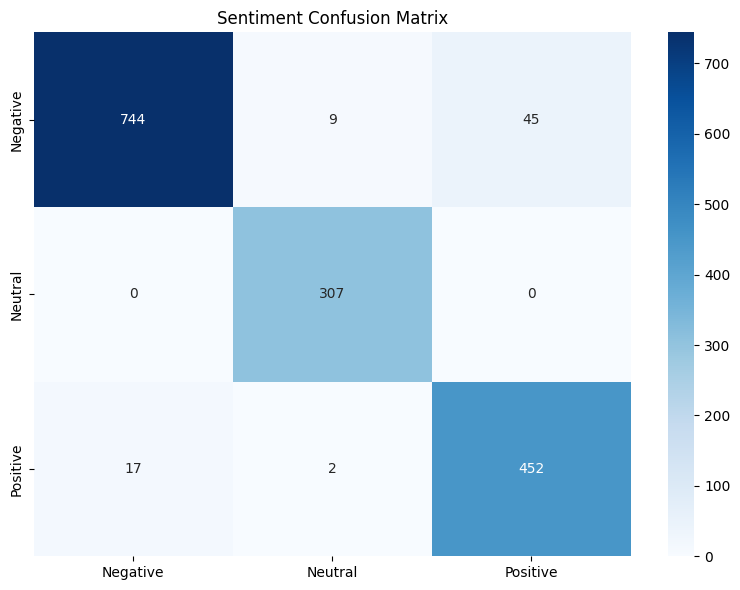


=== SARCASM CLASSIFICATION REPORT ===
               precision    recall  f1-score   support

Non-Sarcastic       0.97      1.00      0.99       541
    Sarcastic       1.00      0.98      0.99      1035

     accuracy                           0.99      1576
    macro avg       0.99      0.99      0.99      1576
 weighted avg       0.99      0.99      0.99      1576



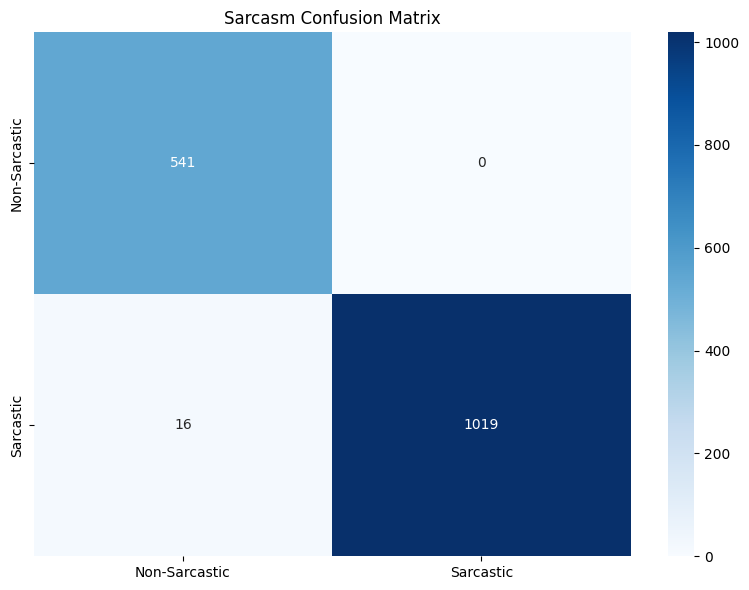


=== VULGAR CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

  Non Vulgar       1.00      0.99      0.99      1090
      Vulgar       0.98      1.00      0.99       486

    accuracy                           0.99      1576
   macro avg       0.99      0.99      0.99      1576
weighted avg       0.99      0.99      0.99      1576



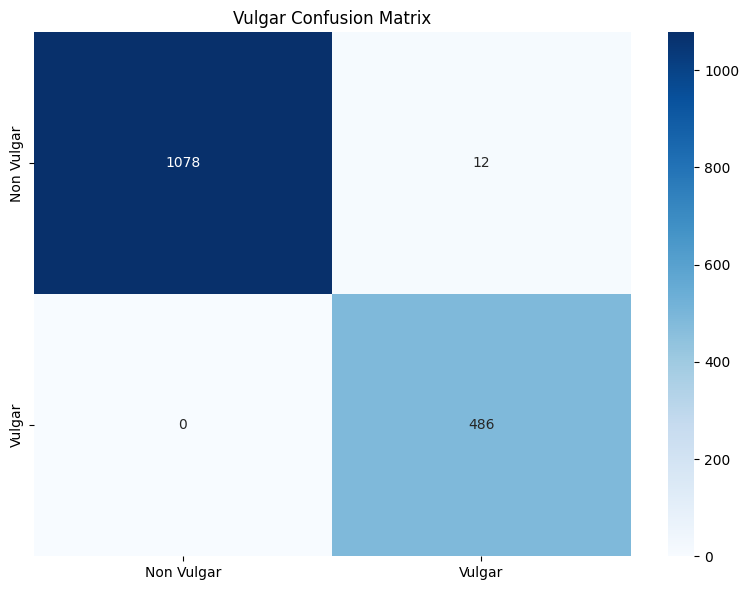


=== ABUSE CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

     Abusive       0.98      0.97      0.97       599
 Non-abusive       0.98      0.99      0.98       977

    accuracy                           0.98      1576
   macro avg       0.98      0.98      0.98      1576
weighted avg       0.98      0.98      0.98      1576



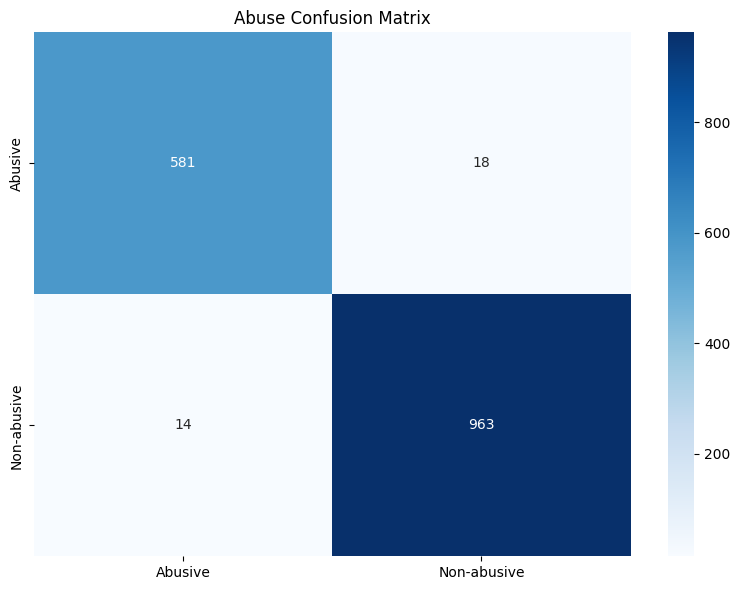


Evaluation saved to: /kaggle/working/evaluation


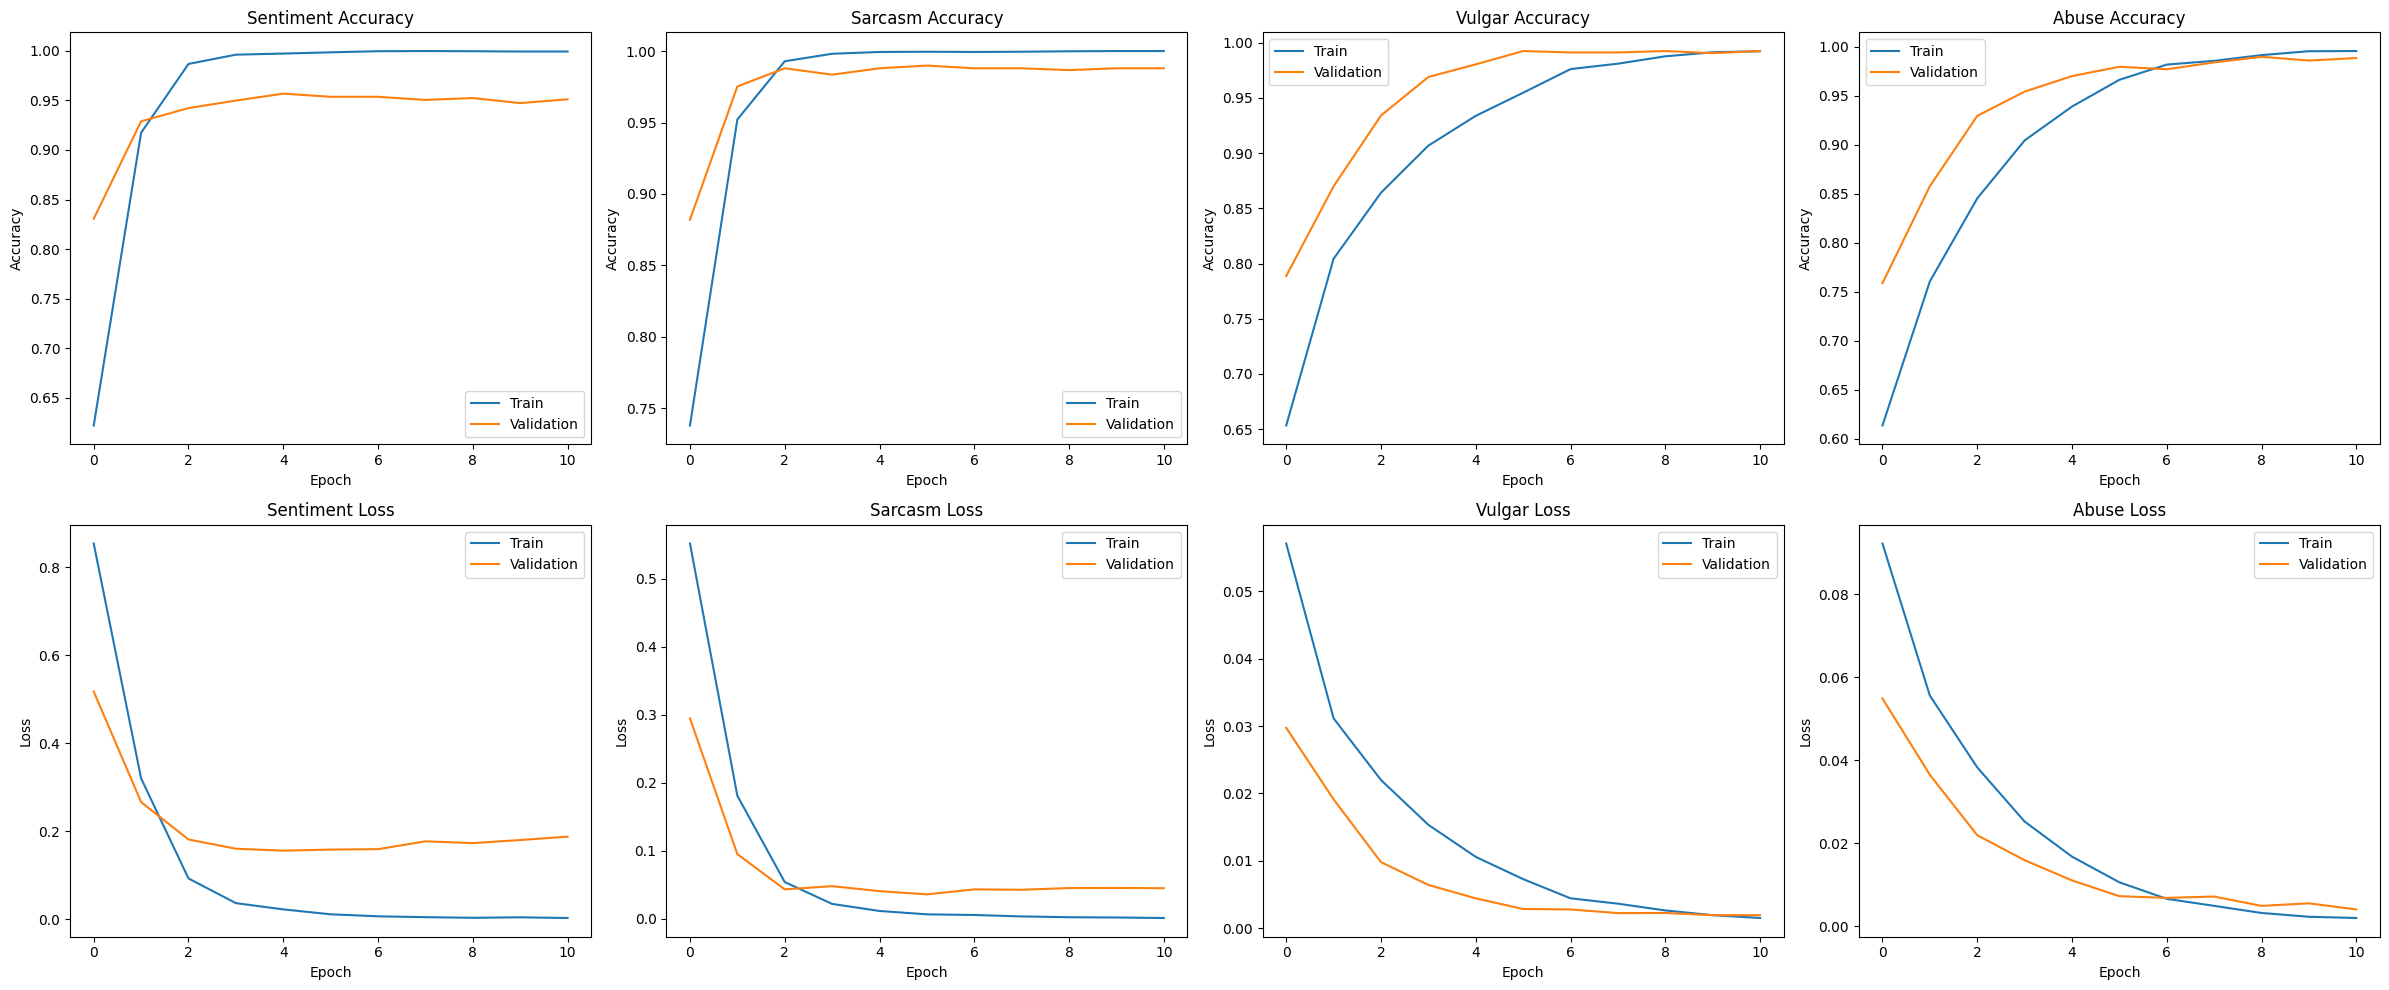

In [8]:
classifier = BanglaMemeClassifier()
    
# Create and train model
train_dataset, val_dataset = classifier.create_datasets(
    csv_path='/kaggle/input/hasoc-train-and-test-dataset/Bangla_train_data.csv',
    image_folder='/kaggle/input/hasoc-train-and-test-dataset/Bangla_train_images'
)

for Xb, yb in val_dataset.take(1):
    print("Label keys:", yb.keys())

classifier.build_model()
classifier.train(train_dataset, val_dataset)

# Evaluate on validation set
out_path = '/kaggle/working/'
classifier.evaluate(val_dataset, out_dir = out_path)

# Generate training plotshow 
classifier.plot_training_history()

# Process test set
test_dataset, test_ids = classifier.create_datasets(
    csv_path='/kaggle/input/hasoc-train-and-test-dataset/bengali_test_data_wo_label.csv',
    image_folder='/kaggle/input/hasoc-train-and-test-dataset/Bangla_test_images',
    is_test=True
)
submission = classifier.predict_test_set(test_dataset, test_ids, out_dir = out_path)
submission.to_csv('/kaggle/working/submission2.csv', index=False)

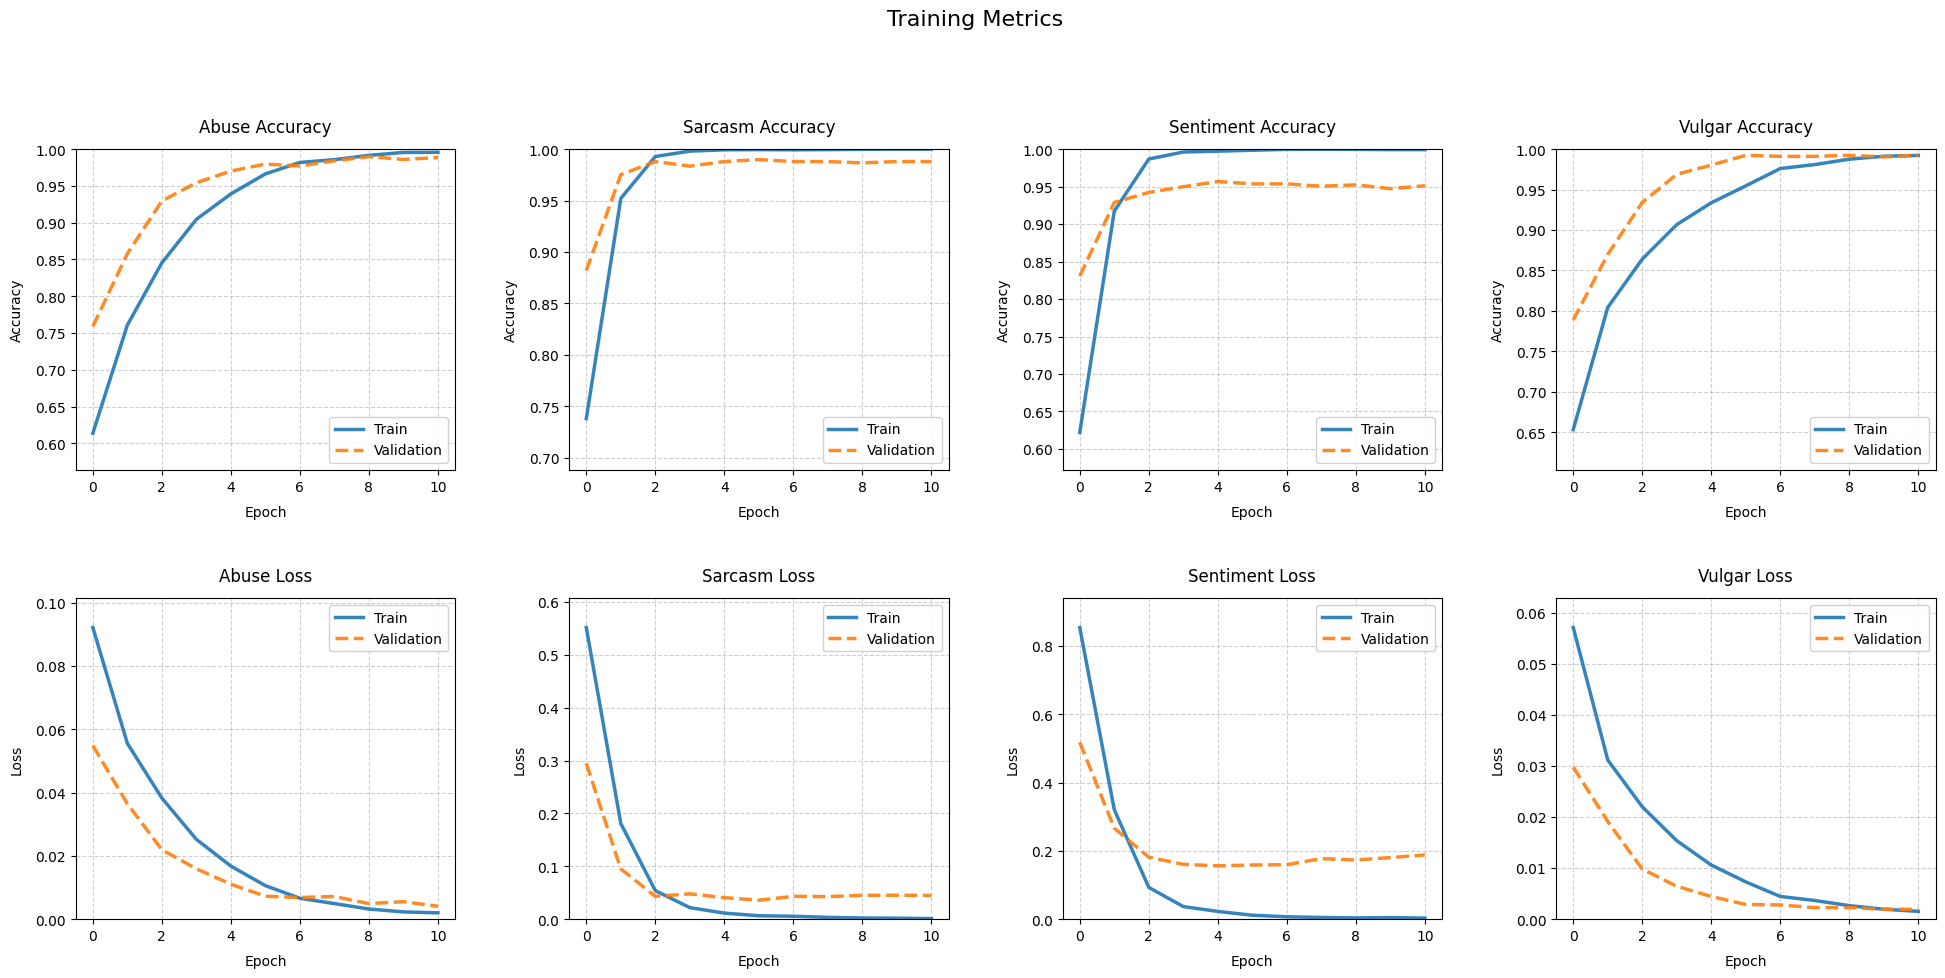

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

def visualize_training_history(history_path='training_history.csv'):
    """Visualize training metrics from CSV history file in a (2,4) grid"""
    # Load training history
    history_df = pd.read_csv(history_path)
    
    # Get list of tasks from column names
    tasks = []
    for col in history_df.columns:
        if '_accuracy' in col and not col.startswith('val_'):
            tasks.append(col.replace('_accuracy', ''))
    
    # Create single figure with 2 rows (accuracy and loss) and 4 columns (tasks)
    fig, axes = plt.subplots(2, 4, figsize=(24, 10))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    
    # Set main title
    fig.suptitle('Training Metrics', fontsize=16, y=1.02)
    
    # Plot accuracy metrics in first row
    for i, task in enumerate(tasks):
        ax = axes[0, i]
        history_df.plot(
            y=[f'{task}_accuracy', f'val_{task}_accuracy'],
            ax=ax,
            style=['-', '--'],
            color=['#1f77b4', '#ff7f0e'],  # Blue and orange
            linewidth=2.5,
            alpha=0.9
        )
        ax.set_title(f'{task.capitalize()} Accuracy', pad=12)
        ax.set_xlabel('Epoch', labelpad=8)
        ax.set_ylabel('Accuracy', labelpad=8)
        ax.legend(['Train', 'Validation'], framealpha=0.9)
        ax.grid(True, linestyle='--', alpha=0.6)
        
        # Set y-axis limits for better visualization
        min_acc = min(history_df[f'{task}_accuracy'].min(), history_df[f'val_{task}_accuracy'].min())
        max_acc = max(history_df[f'{task}_accuracy'].max(), history_df[f'val_{task}_accuracy'].max())
        ax.set_ylim(max(0, min_acc-0.05), min(1, max_acc+0.05))
    
    # Plot loss metrics in second row
    for i, task in enumerate(tasks):
        ax = axes[1, i]
        history_df.plot(
            y=[f'{task}_loss', f'val_{task}_loss'],
            ax=ax,
            style=['-', '--'],
            color=['#1f77b4', '#ff7f0e'],  # Blue and orange
            linewidth=2.5,
            alpha=0.9
        )
        ax.set_title(f'{task.capitalize()} Loss', pad=12)
        ax.set_xlabel('Epoch', labelpad=8)
        ax.set_ylabel('Loss', labelpad=8)
        ax.legend(['Train', 'Validation'], framealpha=0.9)
        ax.grid(True, linestyle='--', alpha=0.6)
        
        # Set y-axis limits for better visualization
        max_loss = max(history_df[f'{task}_loss'].max(), history_df[f'val_{task}_loss'].max())
        ax.set_ylim(0, max_loss*1.1)
    
    # Display in notebook
    display(fig)
    
    # Save figure
    fig.savefig('training_metrics.png', bbox_inches='tight', dpi=300, facecolor='white')
    
    # Close figure to prevent memory issues
    plt.close(fig)

# Usage in Kaggle notebook
visualize_training_history('training_history.csv')

In [10]:
import pandas as pd
import numpy as np

test_csv = "/kaggle/input/hasoc-train-and-test-dataset/bengali_test_data_wo_label.csv"
sub_csv  = "/kaggle/working/submission.csv"

# Read as strings to avoid surprises (e.g., leading zeros)
test = pd.read_csv(test_csv, dtype={"Ids": str})
sub  = pd.read_csv(sub_csv,  dtype={"Ids": str})

print(f"test rows: {len(test)}, unique Ids: {test['Ids'].nunique()}")
print(f"sub  rows: {len(sub)},  unique Ids: {sub['Ids'].nunique()}")

# 1) Quick exact check (same length AND same order)
same_len = len(test) == len(sub)
same_order = same_len and np.array_equal(test["Ids"].values, sub["Ids"].values)

print("Same length:", same_len)
print("Row-by-row Ids identical:", same_order)

# 2) If not identical, show what’s wrong
if not same_order:
    n = min(len(test), len(sub))
    mism_idx = np.where(test["Ids"].values[:n] != sub["Ids"].values[:n])[0]
    print("Mismatched rows:", len(mism_idx))
    for i in mism_idx[:10]:
        print(f"{i}: test={test['Ids'].iloc[i]}  sub={sub['Ids'].iloc[i]}")

    same_set = set(test["Ids"]) == set(sub["Ids"])
    print("Same Ids ignoring order:", same_set)

    missing_in_sub = set(test["Ids"]) - set(sub["Ids"])
    extra_in_sub   = set(sub["Ids"])  - set(test["Ids"])
    print("Missing in submission:", len(missing_in_sub))
    print("Extra in submission:", len(extra_in_sub))

    # 3) If it’s only an ordering issue, realign submission to test order
    if same_set and len(missing_in_sub) == 0 and len(extra_in_sub) == 0:
        sub_aligned = sub.set_index("Ids").reindex(test["Ids"]).reset_index()
        # Keep same column order as your original submission
        sub_aligned = sub_aligned[sub.columns]
        out_path = "/kaggle/working/submission_aligned.csv"
        sub_aligned.to_csv(out_path, index=False)
        print("Saved order-fixed file to:", out_path)

# Optional: hard assert to fail fast if anything is off
# pd.testing.assert_series_equal(
#     test["Ids"].reset_index(drop=True),
#     sub["Ids"].reset_index(drop=True),
#     check_names=False
# )


test rows: 1821, unique Ids: 1821
sub  rows: 1821,  unique Ids: 1821
Same length: True
Row-by-row Ids identical: True
